# Spooky author classification challenge

- Predict the author based on snippets from their books.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 

from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline


from keras.models import Model, Sequential
from keras.layers import Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils import np_utils

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_sub = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print(train.shape)
print(test.shape)

(19579, 3)
(8392, 2)


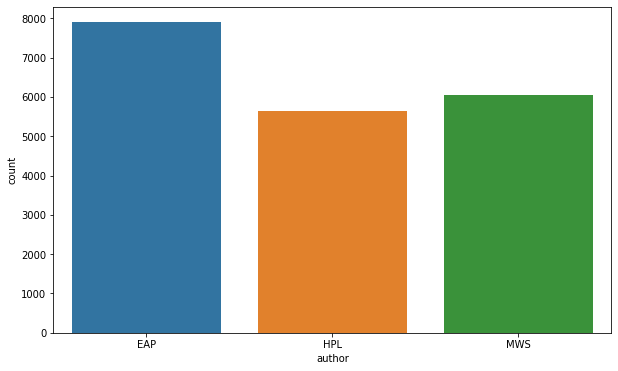

In [5]:
plt.figure(figsize = (10,6))
sns.countplot(train.author);

There's only a slight imbalance in the target class.

- **Map the author name abbreviations to integers.**

In [6]:
lbl_enc = LabelEncoder()
lbl_enc.fit(train.author)
train.loc[:, 'author'] = lbl_enc.transform(train.author)

### Text preprocessing
- Remove stopwords
- Lemmatize

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 



def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [w for w in tokenizer.tokenize(text.lower()) if not w in stop_words]  # convert to lowercase and remove stopwords
##    words = [w for w in words if len(w)>2] # remove words less than 3 letters long, not used here
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w, pos= get_wordnet_pos(w)) for w in words]) ## lemmatization
    return lemmatized_text

In [8]:
# Apply the preprocessing steps to the train text adn the test text
train.loc[:, 'text'] = train.text.apply(lambda text: preprocess_text(text))
test.loc[:, 'text'] = test.text.apply(lambda text: preprocess_text(text))

In [9]:
train.text.apply(lambda snippet: len(snippet)).describe()

count    19579.000000
mean        88.644568
std         65.975348
min          0.000000
25%         46.000000
50%         76.000000
75%        116.000000
max       2854.000000
Name: text, dtype: float64

- The texts have a mean length of ~ 88 characters.
- Few texts have zero length because they consist only of stopwords. We would remove those training examples since they are redundant.

In [10]:
ind_to_drop = np.where(train.text.apply(lambda s: len(s)==0))[0]
ind_to_drop

array([ 477, 1023, 3601, 8654])

In [11]:
train = train.drop(ind_to_drop,axis=0)

max length: 2854


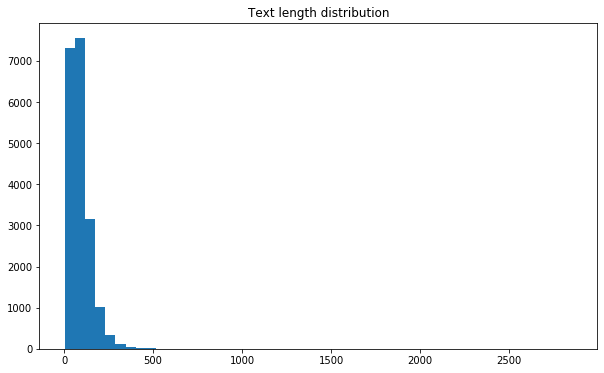

In [12]:
# Distribution of the text lengths (characters)

MAX_LENGTH = max(map(len, train.text))
print("max length:", MAX_LENGTH)
plt.figure(figsize = (10,6))
plt.title('Text length distribution')
plt.hist(list(map(len, train.text)), bins=50);

### Train-test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=1010, stratify = train.author)

### Vectorizer
- I've tried both TF-IDF and Count vectorizer.

In [14]:
# Consider unigrams through tri-grams for word level vectorizers, consider only top 30000 tokens.


tfidf = TfidfVectorizer(ngram_range = (1,3), strip_accents= 'unicode',
                       max_df= 0.8,  analyzer= 'word', 
                       max_features = 30000, sublinear_tf=True)


count_vec = CountVectorizer(ngram_range = (1,3), strip_accents= 'unicode',
                       max_df= 0.8, analyzer= 'word', 
                       max_features = 30000)


## Fit on the training set
tfidf.fit(X_train.text)
count_vec.fit(X_train.text)

# Transform both the training set and the test set with the transformer
tfidf_train = tfidf.transform(X_train.text)
tfidf_test = tfidf.transform(X_test.text)

countvec_train = count_vec.transform(X_train.text)
countvec_test = count_vec.transform(X_test.text)

In [15]:
print(tfidf_train.shape)
print(tfidf_test.shape)
print(countvec_train.shape)
print(countvec_test.shape)
print(train_tfidf_char.shape)
print(test_tfidf_char.shape)

(15660, 30000)
(3915, 30000)
(15660, 30000)
(3915, 30000)
(15660, 50000)
(3915, 50000)


In [16]:
def get_top_n_tokens(vectorizer, vectorizer_name, df, top_n = 5):

    feature_names = vectorizer.get_feature_names()
    scores = np.sum(df.A, axis=0,keepdims=False)
    p=[]
    for tag, score in zip(feature_names, scores):
        p.append((tag, score))
    scores_df = pd.DataFrame(p,columns=['token', '%s score'%(vectorizer_name)]).sort_values(by = '%s score'%(vectorizer_name), ascending=False)
    return scores_df.head(top_n)

In [17]:
get_top_n_tokens(tfidf, 'tfidf', tfidf_train, top_n = 5)

,token,tfidf score
16044,one,152.992027
22712,say,140.648254
4201,could,135.041196
29495,would,127.997811
27363,upon,126.798372


In [18]:
#get_top_n_tokens(count_vec, 'Count_vec', countvec_train, top_n = 5)

### Predictive modelling

In [19]:
def grid_search(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None,verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=5, verbose =verbose)
    gs.fit(X, y)
    print ("Best parameter values: {}\n Best mean CV score = {:.4} and std. dev. = {:.4}".format(gs.best_params_ , 
                                                                      gs.best_score_, 
                                                                      gs.cv_results_['std_test_score'][gs.best_index_]))
    best = gs.best_estimator_
    return best

def show_metrics(y_test,y_pred, y_pred_proba):
    print(classification_report(y_test, y_pred ))
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns= ['Predicted EAP', 'Predicted HPL', 'predicted MWS'], 
                         index = ['Actual EAP', 'Actual HPL', 'Actual MWS']))
    print('The multiclass logloss is {}'.format(log_loss(y_test, y_pred_proba)))
    
mlogloss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

### Naive Bayes

In [20]:
## With tfidf word-level features 

clf_mulNB = MultinomialNB()
parameters = {'alpha': np.arange(0.01, 0.1, 0.01)}
mulNB_model = grid_search(clf_mulNB, parameters, tfidf_train, y_train, n_folds=5, score_func= mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,mulNB_model.predict_proba(tfidf_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,mulNB_model.predict_proba(tfidf_test))))

Best parameter values: {'alpha': 0.04}
 Best mean CV score = -0.4323 and std. dev. = 0.006992
Train logloss: 0.1414
Test logloss: 0.4269


- The model appears to have overfit.
- There are a few things which one can try, Let's see how the training and test losses vary as a function of $\alpha$.

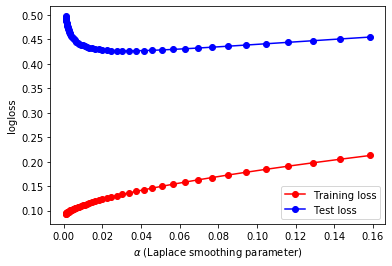

In [72]:
train_losses = []
test_losses = []
alphas = np.logspace(-3,-0.8,num = 50)
#alphas = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]
for alpha in alphas:
    clf_mulNB = MultinomialNB(alpha = alpha)
    clf_mulNB.fit(tfidf_train, y_train)
    train_losses.append(log_loss(y_train,clf_mulNB.predict_proba(tfidf_train)))
    test_losses.append(log_loss(y_test,clf_mulNB.predict_proba(tfidf_test)))

plt.plot(alphas, train_losses, 'ro-', label = 'Training loss');
plt.plot(alphas, test_losses, 'bo-', label = 'Test loss');
plt.xlabel(r'$\alpha$ (Laplace smoothing parameter)');
plt.ylabel('logloss')
plt.legend();

- From the plot above, one can see that the model starts to overfit at $\alpha \lesssim 0.03$.
- Tf-idf vectorizer also has parameters

In [98]:
clf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', max_df= 0.8)),    
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])

# parameter tuning with grid search
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'vect__max_features': [None, 10000, 30000],
              'tfidf__use_idf': (True, False),
              'clf__alpha': np.arange(0.01, 0.1, 0.01),
}
gs_clf = grid_search(clf, parameters, X_train.text, y_train, n_folds = 5, score_func = mlogloss)

Best parameter values: {'clf__alpha': 0.02, 'tfidf__use_idf': False, 'vect__max_features': None, 'vect__ngram_range': (1, 2)}
 Best mean CV score = -0.4217 and std. dev. = 0.00734


In [99]:
print('Train logloss: {:.4}'.format(log_loss(y_train,gs_clf.predict_proba(X_train.text))))
print('Test logloss: {:.4}'.format(log_loss(y_test,gs_clf.predict_proba(X_test.text))))

Train logloss: 0.01606
Test logloss: 0.4037


In [21]:
# tf-idf with 10,000 features

tfidf2 = TfidfVectorizer(ngram_range = (1,3), strip_accents= 'unicode',
                        analyzer= 'word', 
                       max_features = 10000, sublinear_tf=True)

## Fit on the training set
tfidf2.fit(X_train.text)


# Transform both the training set and the test set with the transformer
tfidf_train2 = tfidf2.transform(X_train.text)
tfidf_test2 = tfidf2.transform(X_test.text)

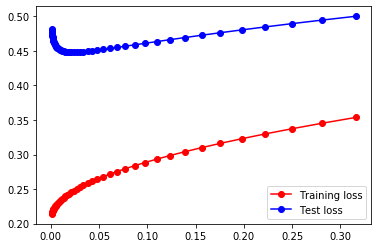

In [59]:
#clf_mulNB2 = MultinomialNB(alpha = 0.4)

#clf_mulNB2.fit(tfidf_train2, y_train)

#print('Train logloss: {:.4}'.format(log_loss(y_train,clf_mulNB2.predict_proba(tfidf_train2))))
#print('Test logloss: {:.4}'.format(log_loss(y_test,clf_mulNB2.predict_proba(tfidf_test2))))

train_losses = []
test_losses = []
alphas = np.logspace(-3,-0.5,num = 50)
#alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
for alpha in alphas:
    clf_mulNB2 = MultinomialNB(alpha = alpha)
    clf_mulNB2.fit(tfidf_train2, y_train)
    train_losses.append(log_loss(y_train,clf_mulNB2.predict_proba(tfidf_train2)))
    test_losses.append(log_loss(y_test,clf_mulNB2.predict_proba(tfidf_test2)))

plt.plot(alphas, train_losses, 'ro-', label = 'Training loss');
plt.plot(alphas, test_losses, 'bo-', label = 'Test loss');
plt.legend();

In [76]:
# With word count features

clf_mulNBcount = MultinomialNB()
parameters = {'alpha': np.arange(0.05,3,0.5)}
mulNB_count_word = grid_search(clf_mulNBcount, parameters, countvec_train, y_train, n_folds = 5, score_func= mlogloss)


print('Train logloss: {:.4}'.format(log_loss(y_train,mulNB_count_word.predict_proba(countvec_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,mulNB_count_word.predict_proba(countvec_test))))

Best parameter values: {'alpha': 2.05}
 Best mean CV score = -0.4613 and std. dev. = 0.00954
Train logloss: 0.2331
Test logloss: 0.476


In [251]:
## With tfidf char-level features 

clf_mulNB_char = MultinomialNB()
parameters = {'alpha': [0.5,1]}
mulNB_tfidf_char = grid_search(clf_mulNB_char, parameters, train_tfidf_char, y_train, n_folds = 5, score_func= mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,mulNB_tfidf_char.predict_proba(train_tfidf_char))))
print('Test logloss: {:.4}'.format(log_loss(y_test,mulNB_tfidf_char.predict_proba(test_tfidf_char))))

Best parameter values: {'alpha': 0.5}
 Best mean CV score = -0.5687 and std. dev. = 0.01026
Train logloss: 0.4265
Test logloss: 0.5535


In [261]:
tfidf_char = TfidfVectorizer(ngram_range = (1,6), strip_accents= 'unicode',
                        analyzer= 'char', max_features = 50000,
                        sublinear_tf=True)

tfidf_char.fit(X_train.text)
train_tfidf_char = tfidf_char.transform(X_train.text)
test_tfidf_char = tfidf_char.transform(X_test.text)

In [274]:
clf_mulNB_char = MultinomialNB(alpha=0.8)
clf_mulNB_char.fit(train_tfidf_char, y_train)

print('Train logloss: {:.4}'.format(log_loss(y_train,clf_mulNB_char.predict_proba(train_tfidf_char))))
print('Test logloss: {:.4}'.format(log_loss(y_test,clf_mulNB_char.predict_proba(test_tfidf_char))))

Train logloss: 0.4554
Test logloss: 0.5682


#### Logistic regression

In [303]:
# with tf-idf word features

clf_logreg = LogisticRegression(solver = 'sag',random_state=23, class_weight= 'balanced')
parameters = {'C': [0.1,0.5, 1]}
logreg_model_tfidf = grid_search(clf_logreg, parameters, tfidf_train2, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,logreg_model_tfidf.predict_proba(tfidf_train2))))
print('Test logloss: {:.4}'.format(log_loss(y_test,logreg_model_tfidf.predict_proba(tfidf_test2))))

Best parameter values: {'C': 1}
 Best mean CV score = -0.578 and std. dev. = 0.007563
Train logloss: 0.4141
Test logloss: 0.5476


In [221]:
# With word count features

clf_logreg_count = LogisticRegression(solver = 'sag', random_state=23, class_weight= 'balanced', max_iter = 1000)
parameters = {'C': [0.1, 0.5, 1, 2,3]}
logreg_model_count = grid_search(clf_logreg_count, parameters, countvec_train, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,logreg_model_count.predict_proba(countvec_train))))
print('Test logloss: {:.4}'.format(log_loss(y_test,logreg_model_count.predict_proba(countvec_test))))

Best parameter values: {'C': 1}
 Best mean CV score = -0.4943 and std. dev. = 0.01323
Train logloss: 0.1504
Test logloss: 0.4703


In [173]:
# Perform SVD with tf-idf char level features

svd = TruncatedSVD(n_components = 100)
svd.fit(train_tfidf_char)
train_svd_tfidf = svd.transform(train_tfidf_char)
test_svd_tfidf = svd.transform(test_tfidf_char)

In [174]:
logreg_tfidf_svd = LogisticRegression(random_state=23, class_weight= 'balanced')
parameters = {'C': np.arange(0.1,1,0.01)}
logreg_model_svd = grid_search(logreg_tfidf_svd, parameters, train_svd_tfidf, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: {:.4}'.format(log_loss(y_train,logreg_model_svd.predict_proba(train_svd_tfidf))))
print('Test logloss: {:.4}'.format(log_loss(y_test,logreg_model_svd.predict_proba(test_svd_tfidf))))

Best parameter values: {'C': 0.9899999999999995}
 Best mean CV score = -0.7979 and std. dev. = 0.008417
Train logloss: 0.7842
Test logloss: 0.7931


#### XGBoost

In [315]:
# with tf-idf word level features

xgb_model = XGBClassifier(max_depth= 2, n_estimators= 2500, n_jobs=-1,learning_rate=0.1, reg_lambda=1.5,
                          colsample_bytree = 0.4, colsample_bylevel = 0.5, random_state=22, subsample = 0.2)
xgb_model.fit(tfidf_train2, y_train, eval_metric =  ['mlogloss'], eval_set = [(tfidf_train2,y_train), (tfidf_test2, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.08637	validation_1-mlogloss:1.08659
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.07616	validation_1-mlogloss:1.07659
[2]	validation_0-mlogloss:1.06502	validation_1-mlogloss:1.06569
[3]	validation_0-mlogloss:1.05686	validation_1-mlogloss:1.05712
[4]	validation_0-mlogloss:1.04600	validation_1-mlogloss:1.04662
[5]	validation_0-mlogloss:1.03857	validation_1-mlogloss:1.03978
[6]	validation_0-mlogloss:1.03218	validation_1-mlogloss:1.03398
[7]	validation_0-mlogloss:1.02418	validation_1-mlogloss:1.02655
[8]	validation_0-mlogloss:1.01805	validation_1-mlogloss:1.02055
[9]	validation_0-mlogloss:1.01042	validation_1-mlogloss:1.01405
[10]	validation_0-mlogloss:1.00507	validation_1-mlogloss:1.00840
[11]	validation_0-mlogloss:1.00003	validation_1-mlogloss:1.00317
[12]	validation_0-mlogloss:0.99557	validation_1-mlogloss:0.9988

[124]	validation_0-mlogloss:0.76842	validation_1-mlogloss:0.80617
[125]	validation_0-mlogloss:0.76739	validation_1-mlogloss:0.80577
[126]	validation_0-mlogloss:0.76629	validation_1-mlogloss:0.80502
[127]	validation_0-mlogloss:0.76517	validation_1-mlogloss:0.80407
[128]	validation_0-mlogloss:0.76402	validation_1-mlogloss:0.80323
[129]	validation_0-mlogloss:0.76296	validation_1-mlogloss:0.80241
[130]	validation_0-mlogloss:0.76193	validation_1-mlogloss:0.80121
[131]	validation_0-mlogloss:0.76084	validation_1-mlogloss:0.80090
[132]	validation_0-mlogloss:0.75980	validation_1-mlogloss:0.80046
[133]	validation_0-mlogloss:0.75874	validation_1-mlogloss:0.79987
[134]	validation_0-mlogloss:0.75774	validation_1-mlogloss:0.79924
[135]	validation_0-mlogloss:0.75674	validation_1-mlogloss:0.79843
[136]	validation_0-mlogloss:0.75573	validation_1-mlogloss:0.79750
[137]	validation_0-mlogloss:0.75473	validation_1-mlogloss:0.79670
[138]	validation_0-mlogloss:0.75368	validation_1-mlogloss:0.79607
[139]	vali

[249]	validation_0-mlogloss:0.66376	validation_1-mlogloss:0.73285
[250]	validation_0-mlogloss:0.66315	validation_1-mlogloss:0.73245
[251]	validation_0-mlogloss:0.66248	validation_1-mlogloss:0.73193
[252]	validation_0-mlogloss:0.66179	validation_1-mlogloss:0.73159
[253]	validation_0-mlogloss:0.66116	validation_1-mlogloss:0.73119
[254]	validation_0-mlogloss:0.66051	validation_1-mlogloss:0.73078
[255]	validation_0-mlogloss:0.65985	validation_1-mlogloss:0.73034
[256]	validation_0-mlogloss:0.65920	validation_1-mlogloss:0.73003
[257]	validation_0-mlogloss:0.65849	validation_1-mlogloss:0.72970
[258]	validation_0-mlogloss:0.65787	validation_1-mlogloss:0.72948
[259]	validation_0-mlogloss:0.65726	validation_1-mlogloss:0.72878
[260]	validation_0-mlogloss:0.65666	validation_1-mlogloss:0.72843
[261]	validation_0-mlogloss:0.65599	validation_1-mlogloss:0.72772
[262]	validation_0-mlogloss:0.65539	validation_1-mlogloss:0.72753
[263]	validation_0-mlogloss:0.65480	validation_1-mlogloss:0.72721
[264]	vali

[374]	validation_0-mlogloss:0.59544	validation_1-mlogloss:0.68727
[375]	validation_0-mlogloss:0.59499	validation_1-mlogloss:0.68687
[376]	validation_0-mlogloss:0.59451	validation_1-mlogloss:0.68665
[377]	validation_0-mlogloss:0.59403	validation_1-mlogloss:0.68628
[378]	validation_0-mlogloss:0.59360	validation_1-mlogloss:0.68629
[379]	validation_0-mlogloss:0.59317	validation_1-mlogloss:0.68596
[380]	validation_0-mlogloss:0.59273	validation_1-mlogloss:0.68575
[381]	validation_0-mlogloss:0.59228	validation_1-mlogloss:0.68549
[382]	validation_0-mlogloss:0.59182	validation_1-mlogloss:0.68515
[383]	validation_0-mlogloss:0.59139	validation_1-mlogloss:0.68478
[384]	validation_0-mlogloss:0.59091	validation_1-mlogloss:0.68443
[385]	validation_0-mlogloss:0.59040	validation_1-mlogloss:0.68413
[386]	validation_0-mlogloss:0.58996	validation_1-mlogloss:0.68383
[387]	validation_0-mlogloss:0.58952	validation_1-mlogloss:0.68344
[388]	validation_0-mlogloss:0.58907	validation_1-mlogloss:0.68315
[389]	vali

[499]	validation_0-mlogloss:0.54481	validation_1-mlogloss:0.65667
[500]	validation_0-mlogloss:0.54445	validation_1-mlogloss:0.65632
[501]	validation_0-mlogloss:0.54412	validation_1-mlogloss:0.65614
[502]	validation_0-mlogloss:0.54377	validation_1-mlogloss:0.65594
[503]	validation_0-mlogloss:0.54341	validation_1-mlogloss:0.65566
[504]	validation_0-mlogloss:0.54306	validation_1-mlogloss:0.65555
[505]	validation_0-mlogloss:0.54267	validation_1-mlogloss:0.65525
[506]	validation_0-mlogloss:0.54232	validation_1-mlogloss:0.65504
[507]	validation_0-mlogloss:0.54197	validation_1-mlogloss:0.65496
[508]	validation_0-mlogloss:0.54158	validation_1-mlogloss:0.65477
[509]	validation_0-mlogloss:0.54126	validation_1-mlogloss:0.65471
[510]	validation_0-mlogloss:0.54093	validation_1-mlogloss:0.65460
[511]	validation_0-mlogloss:0.54057	validation_1-mlogloss:0.65451
[512]	validation_0-mlogloss:0.54022	validation_1-mlogloss:0.65445
[513]	validation_0-mlogloss:0.53987	validation_1-mlogloss:0.65419
[514]	vali

[624]	validation_0-mlogloss:0.50435	validation_1-mlogloss:0.63506
[625]	validation_0-mlogloss:0.50406	validation_1-mlogloss:0.63497
[626]	validation_0-mlogloss:0.50379	validation_1-mlogloss:0.63500
[627]	validation_0-mlogloss:0.50350	validation_1-mlogloss:0.63468
[628]	validation_0-mlogloss:0.50322	validation_1-mlogloss:0.63434
[629]	validation_0-mlogloss:0.50289	validation_1-mlogloss:0.63431
[630]	validation_0-mlogloss:0.50261	validation_1-mlogloss:0.63419
[631]	validation_0-mlogloss:0.50233	validation_1-mlogloss:0.63395
[632]	validation_0-mlogloss:0.50206	validation_1-mlogloss:0.63382
[633]	validation_0-mlogloss:0.50176	validation_1-mlogloss:0.63355
[634]	validation_0-mlogloss:0.50148	validation_1-mlogloss:0.63336
[635]	validation_0-mlogloss:0.50120	validation_1-mlogloss:0.63330
[636]	validation_0-mlogloss:0.50092	validation_1-mlogloss:0.63310
[637]	validation_0-mlogloss:0.50064	validation_1-mlogloss:0.63284
[638]	validation_0-mlogloss:0.50038	validation_1-mlogloss:0.63272
[639]	vali

[749]	validation_0-mlogloss:0.47108	validation_1-mlogloss:0.61819
[750]	validation_0-mlogloss:0.47086	validation_1-mlogloss:0.61799
[751]	validation_0-mlogloss:0.47062	validation_1-mlogloss:0.61793
[752]	validation_0-mlogloss:0.47038	validation_1-mlogloss:0.61776
[753]	validation_0-mlogloss:0.47011	validation_1-mlogloss:0.61764
[754]	validation_0-mlogloss:0.46989	validation_1-mlogloss:0.61761
[755]	validation_0-mlogloss:0.46963	validation_1-mlogloss:0.61762
[756]	validation_0-mlogloss:0.46938	validation_1-mlogloss:0.61741
[757]	validation_0-mlogloss:0.46907	validation_1-mlogloss:0.61741
[758]	validation_0-mlogloss:0.46885	validation_1-mlogloss:0.61731
[759]	validation_0-mlogloss:0.46865	validation_1-mlogloss:0.61710
[760]	validation_0-mlogloss:0.46840	validation_1-mlogloss:0.61704
[761]	validation_0-mlogloss:0.46815	validation_1-mlogloss:0.61692
[762]	validation_0-mlogloss:0.46790	validation_1-mlogloss:0.61665
[763]	validation_0-mlogloss:0.46768	validation_1-mlogloss:0.61645
[764]	vali

[874]	validation_0-mlogloss:0.44272	validation_1-mlogloss:0.60540
[875]	validation_0-mlogloss:0.44250	validation_1-mlogloss:0.60528
[876]	validation_0-mlogloss:0.44228	validation_1-mlogloss:0.60524
[877]	validation_0-mlogloss:0.44209	validation_1-mlogloss:0.60509
[878]	validation_0-mlogloss:0.44185	validation_1-mlogloss:0.60506
[879]	validation_0-mlogloss:0.44165	validation_1-mlogloss:0.60491
[880]	validation_0-mlogloss:0.44144	validation_1-mlogloss:0.60466
[881]	validation_0-mlogloss:0.44121	validation_1-mlogloss:0.60477
[882]	validation_0-mlogloss:0.44102	validation_1-mlogloss:0.60471
[883]	validation_0-mlogloss:0.44081	validation_1-mlogloss:0.60447
[884]	validation_0-mlogloss:0.44060	validation_1-mlogloss:0.60447
[885]	validation_0-mlogloss:0.44040	validation_1-mlogloss:0.60436
[886]	validation_0-mlogloss:0.44020	validation_1-mlogloss:0.60424
[887]	validation_0-mlogloss:0.44001	validation_1-mlogloss:0.60412
[888]	validation_0-mlogloss:0.43981	validation_1-mlogloss:0.60405
[889]	vali

[999]	validation_0-mlogloss:0.41829	validation_1-mlogloss:0.59601
[1000]	validation_0-mlogloss:0.41811	validation_1-mlogloss:0.59596
[1001]	validation_0-mlogloss:0.41792	validation_1-mlogloss:0.59596
[1002]	validation_0-mlogloss:0.41772	validation_1-mlogloss:0.59581
[1003]	validation_0-mlogloss:0.41754	validation_1-mlogloss:0.59578
[1004]	validation_0-mlogloss:0.41736	validation_1-mlogloss:0.59575
[1005]	validation_0-mlogloss:0.41720	validation_1-mlogloss:0.59572
[1006]	validation_0-mlogloss:0.41701	validation_1-mlogloss:0.59562
[1007]	validation_0-mlogloss:0.41682	validation_1-mlogloss:0.59548
[1008]	validation_0-mlogloss:0.41661	validation_1-mlogloss:0.59538
[1009]	validation_0-mlogloss:0.41642	validation_1-mlogloss:0.59532
[1010]	validation_0-mlogloss:0.41622	validation_1-mlogloss:0.59530
[1011]	validation_0-mlogloss:0.41601	validation_1-mlogloss:0.59524
[1012]	validation_0-mlogloss:0.41584	validation_1-mlogloss:0.59512
[1013]	validation_0-mlogloss:0.41565	validation_1-mlogloss:0.59

[1122]	validation_0-mlogloss:0.39721	validation_1-mlogloss:0.58690
[1123]	validation_0-mlogloss:0.39704	validation_1-mlogloss:0.58664
[1124]	validation_0-mlogloss:0.39687	validation_1-mlogloss:0.58678
[1125]	validation_0-mlogloss:0.39670	validation_1-mlogloss:0.58660
[1126]	validation_0-mlogloss:0.39653	validation_1-mlogloss:0.58655
[1127]	validation_0-mlogloss:0.39638	validation_1-mlogloss:0.58651
[1128]	validation_0-mlogloss:0.39623	validation_1-mlogloss:0.58639
[1129]	validation_0-mlogloss:0.39608	validation_1-mlogloss:0.58641
[1130]	validation_0-mlogloss:0.39593	validation_1-mlogloss:0.58631
[1131]	validation_0-mlogloss:0.39578	validation_1-mlogloss:0.58626
[1132]	validation_0-mlogloss:0.39562	validation_1-mlogloss:0.58608
[1133]	validation_0-mlogloss:0.39547	validation_1-mlogloss:0.58600
[1134]	validation_0-mlogloss:0.39532	validation_1-mlogloss:0.58587
[1135]	validation_0-mlogloss:0.39516	validation_1-mlogloss:0.58590
[1136]	validation_0-mlogloss:0.39498	validation_1-mlogloss:0.5

[1245]	validation_0-mlogloss:0.37859	validation_1-mlogloss:0.58094
[1246]	validation_0-mlogloss:0.37845	validation_1-mlogloss:0.58098
[1247]	validation_0-mlogloss:0.37831	validation_1-mlogloss:0.58095
[1248]	validation_0-mlogloss:0.37815	validation_1-mlogloss:0.58091
[1249]	validation_0-mlogloss:0.37802	validation_1-mlogloss:0.58090
[1250]	validation_0-mlogloss:0.37789	validation_1-mlogloss:0.58080
[1251]	validation_0-mlogloss:0.37775	validation_1-mlogloss:0.58069
[1252]	validation_0-mlogloss:0.37761	validation_1-mlogloss:0.58066
[1253]	validation_0-mlogloss:0.37745	validation_1-mlogloss:0.58072
[1254]	validation_0-mlogloss:0.37731	validation_1-mlogloss:0.58067
[1255]	validation_0-mlogloss:0.37717	validation_1-mlogloss:0.58048
[1256]	validation_0-mlogloss:0.37704	validation_1-mlogloss:0.58038
[1257]	validation_0-mlogloss:0.37691	validation_1-mlogloss:0.58035
[1258]	validation_0-mlogloss:0.37678	validation_1-mlogloss:0.58030
[1259]	validation_0-mlogloss:0.37663	validation_1-mlogloss:0.5

[1368]	validation_0-mlogloss:0.36185	validation_1-mlogloss:0.57593
[1369]	validation_0-mlogloss:0.36173	validation_1-mlogloss:0.57588
[1370]	validation_0-mlogloss:0.36160	validation_1-mlogloss:0.57584
[1371]	validation_0-mlogloss:0.36147	validation_1-mlogloss:0.57586
[1372]	validation_0-mlogloss:0.36133	validation_1-mlogloss:0.57581
[1373]	validation_0-mlogloss:0.36119	validation_1-mlogloss:0.57584
[1374]	validation_0-mlogloss:0.36106	validation_1-mlogloss:0.57579
[1375]	validation_0-mlogloss:0.36094	validation_1-mlogloss:0.57569
[1376]	validation_0-mlogloss:0.36082	validation_1-mlogloss:0.57574
[1377]	validation_0-mlogloss:0.36071	validation_1-mlogloss:0.57567
[1378]	validation_0-mlogloss:0.36056	validation_1-mlogloss:0.57563
[1379]	validation_0-mlogloss:0.36043	validation_1-mlogloss:0.57551
[1380]	validation_0-mlogloss:0.36031	validation_1-mlogloss:0.57543
[1381]	validation_0-mlogloss:0.36019	validation_1-mlogloss:0.57545
[1382]	validation_0-mlogloss:0.36006	validation_1-mlogloss:0.5

[1491]	validation_0-mlogloss:0.34673	validation_1-mlogloss:0.57336
[1492]	validation_0-mlogloss:0.34661	validation_1-mlogloss:0.57330
[1493]	validation_0-mlogloss:0.34652	validation_1-mlogloss:0.57324
[1494]	validation_0-mlogloss:0.34639	validation_1-mlogloss:0.57316
[1495]	validation_0-mlogloss:0.34628	validation_1-mlogloss:0.57322
[1496]	validation_0-mlogloss:0.34619	validation_1-mlogloss:0.57323
[1497]	validation_0-mlogloss:0.34608	validation_1-mlogloss:0.57329
[1498]	validation_0-mlogloss:0.34597	validation_1-mlogloss:0.57338
[1499]	validation_0-mlogloss:0.34586	validation_1-mlogloss:0.57336


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [34]:
# With Count features

xgb_model_count = XGBClassifier(max_depth= 2, n_estimators=2500, n_jobs=-1,learning_rate=0.2, reg_lambda=1.5,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.7)

xgb_model_count.fit(countvec_train, y_train, eval_metric =  ['mlogloss'], eval_set = [(countvec_train,y_train), (countvec_test, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.09017	validation_1-mlogloss:1.09045
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.08201	validation_1-mlogloss:1.08237
[2]	validation_0-mlogloss:1.07403	validation_1-mlogloss:1.07426
[3]	validation_0-mlogloss:1.06330	validation_1-mlogloss:1.06395
[4]	validation_0-mlogloss:1.05578	validation_1-mlogloss:1.05675
[5]	validation_0-mlogloss:1.04964	validation_1-mlogloss:1.05041
[6]	validation_0-mlogloss:1.04485	validation_1-mlogloss:1.04511
[7]	validation_0-mlogloss:1.03946	validation_1-mlogloss:1.03984
[8]	validation_0-mlogloss:1.03453	validation_1-mlogloss:1.03500
[9]	validation_0-mlogloss:1.02903	validation_1-mlogloss:1.02953
[10]	validation_0-mlogloss:1.02530	validation_1-mlogloss:1.02567
[11]	validation_0-mlogloss:1.02024	validation_1-mlogloss:1.02089
[12]	validation_0-mlogloss:1.01668	validation_1-mlogloss:1.0172

[124]	validation_0-mlogloss:0.83478	validation_1-mlogloss:0.84769
[125]	validation_0-mlogloss:0.83386	validation_1-mlogloss:0.84686
[126]	validation_0-mlogloss:0.83292	validation_1-mlogloss:0.84609
[127]	validation_0-mlogloss:0.83203	validation_1-mlogloss:0.84520
[128]	validation_0-mlogloss:0.83115	validation_1-mlogloss:0.84451
[129]	validation_0-mlogloss:0.83026	validation_1-mlogloss:0.84377
[130]	validation_0-mlogloss:0.82937	validation_1-mlogloss:0.84285
[131]	validation_0-mlogloss:0.82850	validation_1-mlogloss:0.84213
[132]	validation_0-mlogloss:0.82758	validation_1-mlogloss:0.84125
[133]	validation_0-mlogloss:0.82664	validation_1-mlogloss:0.84029
[134]	validation_0-mlogloss:0.82574	validation_1-mlogloss:0.83969
[135]	validation_0-mlogloss:0.82490	validation_1-mlogloss:0.83873
[136]	validation_0-mlogloss:0.82405	validation_1-mlogloss:0.83805
[137]	validation_0-mlogloss:0.82318	validation_1-mlogloss:0.83756
[138]	validation_0-mlogloss:0.82233	validation_1-mlogloss:0.83683
[139]	vali

[249]	validation_0-mlogloss:0.74652	validation_1-mlogloss:0.77380
[250]	validation_0-mlogloss:0.74601	validation_1-mlogloss:0.77343
[251]	validation_0-mlogloss:0.74550	validation_1-mlogloss:0.77295
[252]	validation_0-mlogloss:0.74487	validation_1-mlogloss:0.77227
[253]	validation_0-mlogloss:0.74428	validation_1-mlogloss:0.77161
[254]	validation_0-mlogloss:0.74370	validation_1-mlogloss:0.77115
[255]	validation_0-mlogloss:0.74316	validation_1-mlogloss:0.77070
[256]	validation_0-mlogloss:0.74263	validation_1-mlogloss:0.77018
[257]	validation_0-mlogloss:0.74208	validation_1-mlogloss:0.76956
[258]	validation_0-mlogloss:0.74153	validation_1-mlogloss:0.76933
[259]	validation_0-mlogloss:0.74099	validation_1-mlogloss:0.76862
[260]	validation_0-mlogloss:0.74045	validation_1-mlogloss:0.76815
[261]	validation_0-mlogloss:0.73992	validation_1-mlogloss:0.76768
[262]	validation_0-mlogloss:0.73940	validation_1-mlogloss:0.76724
[263]	validation_0-mlogloss:0.73890	validation_1-mlogloss:0.76669
[264]	vali

[374]	validation_0-mlogloss:0.68845	validation_1-mlogloss:0.72646
[375]	validation_0-mlogloss:0.68806	validation_1-mlogloss:0.72620
[376]	validation_0-mlogloss:0.68764	validation_1-mlogloss:0.72570
[377]	validation_0-mlogloss:0.68722	validation_1-mlogloss:0.72529
[378]	validation_0-mlogloss:0.68683	validation_1-mlogloss:0.72506
[379]	validation_0-mlogloss:0.68645	validation_1-mlogloss:0.72464
[380]	validation_0-mlogloss:0.68604	validation_1-mlogloss:0.72421
[381]	validation_0-mlogloss:0.68563	validation_1-mlogloss:0.72395
[382]	validation_0-mlogloss:0.68523	validation_1-mlogloss:0.72365
[383]	validation_0-mlogloss:0.68483	validation_1-mlogloss:0.72308
[384]	validation_0-mlogloss:0.68442	validation_1-mlogloss:0.72283
[385]	validation_0-mlogloss:0.68401	validation_1-mlogloss:0.72252
[386]	validation_0-mlogloss:0.68362	validation_1-mlogloss:0.72218
[387]	validation_0-mlogloss:0.68322	validation_1-mlogloss:0.72197
[388]	validation_0-mlogloss:0.68283	validation_1-mlogloss:0.72185
[389]	vali

[499]	validation_0-mlogloss:0.64405	validation_1-mlogloss:0.69270
[500]	validation_0-mlogloss:0.64374	validation_1-mlogloss:0.69246
[501]	validation_0-mlogloss:0.64343	validation_1-mlogloss:0.69207
[502]	validation_0-mlogloss:0.64312	validation_1-mlogloss:0.69193
[503]	validation_0-mlogloss:0.64278	validation_1-mlogloss:0.69167
[504]	validation_0-mlogloss:0.64249	validation_1-mlogloss:0.69139
[505]	validation_0-mlogloss:0.64220	validation_1-mlogloss:0.69109
[506]	validation_0-mlogloss:0.64189	validation_1-mlogloss:0.69086
[507]	validation_0-mlogloss:0.64158	validation_1-mlogloss:0.69068
[508]	validation_0-mlogloss:0.64128	validation_1-mlogloss:0.69047
[509]	validation_0-mlogloss:0.64097	validation_1-mlogloss:0.69040
[510]	validation_0-mlogloss:0.64068	validation_1-mlogloss:0.69026
[511]	validation_0-mlogloss:0.64037	validation_1-mlogloss:0.68990
[512]	validation_0-mlogloss:0.64000	validation_1-mlogloss:0.68981
[513]	validation_0-mlogloss:0.63969	validation_1-mlogloss:0.68952
[514]	vali

[624]	validation_0-mlogloss:0.60870	validation_1-mlogloss:0.66618
[625]	validation_0-mlogloss:0.60845	validation_1-mlogloss:0.66602
[626]	validation_0-mlogloss:0.60821	validation_1-mlogloss:0.66588
[627]	validation_0-mlogloss:0.60796	validation_1-mlogloss:0.66569
[628]	validation_0-mlogloss:0.60771	validation_1-mlogloss:0.66553
[629]	validation_0-mlogloss:0.60746	validation_1-mlogloss:0.66521
[630]	validation_0-mlogloss:0.60720	validation_1-mlogloss:0.66509
[631]	validation_0-mlogloss:0.60694	validation_1-mlogloss:0.66493
[632]	validation_0-mlogloss:0.60667	validation_1-mlogloss:0.66470
[633]	validation_0-mlogloss:0.60643	validation_1-mlogloss:0.66454
[634]	validation_0-mlogloss:0.60618	validation_1-mlogloss:0.66434
[635]	validation_0-mlogloss:0.60593	validation_1-mlogloss:0.66416
[636]	validation_0-mlogloss:0.60567	validation_1-mlogloss:0.66405
[637]	validation_0-mlogloss:0.60542	validation_1-mlogloss:0.66382
[638]	validation_0-mlogloss:0.60516	validation_1-mlogloss:0.66353
[639]	vali

[749]	validation_0-mlogloss:0.57911	validation_1-mlogloss:0.64478
[750]	validation_0-mlogloss:0.57888	validation_1-mlogloss:0.64440
[751]	validation_0-mlogloss:0.57867	validation_1-mlogloss:0.64411
[752]	validation_0-mlogloss:0.57847	validation_1-mlogloss:0.64403
[753]	validation_0-mlogloss:0.57825	validation_1-mlogloss:0.64401
[754]	validation_0-mlogloss:0.57802	validation_1-mlogloss:0.64380
[755]	validation_0-mlogloss:0.57781	validation_1-mlogloss:0.64362
[756]	validation_0-mlogloss:0.57759	validation_1-mlogloss:0.64339
[757]	validation_0-mlogloss:0.57737	validation_1-mlogloss:0.64319
[758]	validation_0-mlogloss:0.57716	validation_1-mlogloss:0.64299
[759]	validation_0-mlogloss:0.57694	validation_1-mlogloss:0.64285
[760]	validation_0-mlogloss:0.57673	validation_1-mlogloss:0.64284
[761]	validation_0-mlogloss:0.57652	validation_1-mlogloss:0.64265
[762]	validation_0-mlogloss:0.57630	validation_1-mlogloss:0.64246
[763]	validation_0-mlogloss:0.57607	validation_1-mlogloss:0.64234
[764]	vali

[874]	validation_0-mlogloss:0.55396	validation_1-mlogloss:0.62707
[875]	validation_0-mlogloss:0.55378	validation_1-mlogloss:0.62703
[876]	validation_0-mlogloss:0.55359	validation_1-mlogloss:0.62702
[877]	validation_0-mlogloss:0.55342	validation_1-mlogloss:0.62688
[878]	validation_0-mlogloss:0.55324	validation_1-mlogloss:0.62686
[879]	validation_0-mlogloss:0.55305	validation_1-mlogloss:0.62671
[880]	validation_0-mlogloss:0.55287	validation_1-mlogloss:0.62668
[881]	validation_0-mlogloss:0.55265	validation_1-mlogloss:0.62659
[882]	validation_0-mlogloss:0.55247	validation_1-mlogloss:0.62651
[883]	validation_0-mlogloss:0.55228	validation_1-mlogloss:0.62631
[884]	validation_0-mlogloss:0.55209	validation_1-mlogloss:0.62623
[885]	validation_0-mlogloss:0.55192	validation_1-mlogloss:0.62608
[886]	validation_0-mlogloss:0.55174	validation_1-mlogloss:0.62594
[887]	validation_0-mlogloss:0.55152	validation_1-mlogloss:0.62582
[888]	validation_0-mlogloss:0.55134	validation_1-mlogloss:0.62574
[889]	vali

[999]	validation_0-mlogloss:0.53180	validation_1-mlogloss:0.61272
[1000]	validation_0-mlogloss:0.53159	validation_1-mlogloss:0.61247
[1001]	validation_0-mlogloss:0.53142	validation_1-mlogloss:0.61240
[1002]	validation_0-mlogloss:0.53125	validation_1-mlogloss:0.61231
[1003]	validation_0-mlogloss:0.53106	validation_1-mlogloss:0.61213
[1004]	validation_0-mlogloss:0.53089	validation_1-mlogloss:0.61200
[1005]	validation_0-mlogloss:0.53074	validation_1-mlogloss:0.61199
[1006]	validation_0-mlogloss:0.53056	validation_1-mlogloss:0.61181
[1007]	validation_0-mlogloss:0.53039	validation_1-mlogloss:0.61171
[1008]	validation_0-mlogloss:0.53024	validation_1-mlogloss:0.61163
[1009]	validation_0-mlogloss:0.53009	validation_1-mlogloss:0.61145
[1010]	validation_0-mlogloss:0.52990	validation_1-mlogloss:0.61118
[1011]	validation_0-mlogloss:0.52972	validation_1-mlogloss:0.61113
[1012]	validation_0-mlogloss:0.52957	validation_1-mlogloss:0.61105
[1013]	validation_0-mlogloss:0.52941	validation_1-mlogloss:0.61

[1122]	validation_0-mlogloss:0.51253	validation_1-mlogloss:0.60001
[1123]	validation_0-mlogloss:0.51239	validation_1-mlogloss:0.59993
[1124]	validation_0-mlogloss:0.51226	validation_1-mlogloss:0.59984
[1125]	validation_0-mlogloss:0.51209	validation_1-mlogloss:0.59972
[1126]	validation_0-mlogloss:0.51194	validation_1-mlogloss:0.59962
[1127]	validation_0-mlogloss:0.51180	validation_1-mlogloss:0.59958
[1128]	validation_0-mlogloss:0.51167	validation_1-mlogloss:0.59955
[1129]	validation_0-mlogloss:0.51151	validation_1-mlogloss:0.59944
[1130]	validation_0-mlogloss:0.51136	validation_1-mlogloss:0.59932
[1131]	validation_0-mlogloss:0.51121	validation_1-mlogloss:0.59925
[1132]	validation_0-mlogloss:0.51107	validation_1-mlogloss:0.59918
[1133]	validation_0-mlogloss:0.51091	validation_1-mlogloss:0.59898
[1134]	validation_0-mlogloss:0.51078	validation_1-mlogloss:0.59888
[1135]	validation_0-mlogloss:0.51062	validation_1-mlogloss:0.59872
[1136]	validation_0-mlogloss:0.51046	validation_1-mlogloss:0.5

[1245]	validation_0-mlogloss:0.49519	validation_1-mlogloss:0.58788
[1246]	validation_0-mlogloss:0.49506	validation_1-mlogloss:0.58776
[1247]	validation_0-mlogloss:0.49493	validation_1-mlogloss:0.58763
[1248]	validation_0-mlogloss:0.49479	validation_1-mlogloss:0.58756
[1249]	validation_0-mlogloss:0.49465	validation_1-mlogloss:0.58747
[1250]	validation_0-mlogloss:0.49453	validation_1-mlogloss:0.58746
[1251]	validation_0-mlogloss:0.49441	validation_1-mlogloss:0.58730
[1252]	validation_0-mlogloss:0.49427	validation_1-mlogloss:0.58718
[1253]	validation_0-mlogloss:0.49413	validation_1-mlogloss:0.58708
[1254]	validation_0-mlogloss:0.49401	validation_1-mlogloss:0.58709
[1255]	validation_0-mlogloss:0.49387	validation_1-mlogloss:0.58702
[1256]	validation_0-mlogloss:0.49373	validation_1-mlogloss:0.58698
[1257]	validation_0-mlogloss:0.49360	validation_1-mlogloss:0.58687
[1258]	validation_0-mlogloss:0.49347	validation_1-mlogloss:0.58680
[1259]	validation_0-mlogloss:0.49334	validation_1-mlogloss:0.5

[1368]	validation_0-mlogloss:0.47968	validation_1-mlogloss:0.57874
[1369]	validation_0-mlogloss:0.47957	validation_1-mlogloss:0.57860
[1370]	validation_0-mlogloss:0.47945	validation_1-mlogloss:0.57863
[1371]	validation_0-mlogloss:0.47933	validation_1-mlogloss:0.57858
[1372]	validation_0-mlogloss:0.47921	validation_1-mlogloss:0.57847
[1373]	validation_0-mlogloss:0.47910	validation_1-mlogloss:0.57835
[1374]	validation_0-mlogloss:0.47898	validation_1-mlogloss:0.57825
[1375]	validation_0-mlogloss:0.47886	validation_1-mlogloss:0.57816
[1376]	validation_0-mlogloss:0.47874	validation_1-mlogloss:0.57801
[1377]	validation_0-mlogloss:0.47863	validation_1-mlogloss:0.57791
[1378]	validation_0-mlogloss:0.47850	validation_1-mlogloss:0.57788
[1379]	validation_0-mlogloss:0.47838	validation_1-mlogloss:0.57775
[1380]	validation_0-mlogloss:0.47827	validation_1-mlogloss:0.57771
[1381]	validation_0-mlogloss:0.47814	validation_1-mlogloss:0.57763
[1382]	validation_0-mlogloss:0.47801	validation_1-mlogloss:0.5

[1491]	validation_0-mlogloss:0.46555	validation_1-mlogloss:0.56989
[1492]	validation_0-mlogloss:0.46543	validation_1-mlogloss:0.56983
[1493]	validation_0-mlogloss:0.46532	validation_1-mlogloss:0.56972
[1494]	validation_0-mlogloss:0.46521	validation_1-mlogloss:0.56963
[1495]	validation_0-mlogloss:0.46509	validation_1-mlogloss:0.56952
[1496]	validation_0-mlogloss:0.46497	validation_1-mlogloss:0.56943
[1497]	validation_0-mlogloss:0.46486	validation_1-mlogloss:0.56937
[1498]	validation_0-mlogloss:0.46475	validation_1-mlogloss:0.56935
[1499]	validation_0-mlogloss:0.46462	validation_1-mlogloss:0.56924


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [314]:
# with tf-idf SVD features

xgb_model = XGBClassifier(max_depth= 2, n_estimators= 1000, n_jobs=-1,learning_rate=0.1, reg_lambda=1.5,
                          colsample_bytree = 0.7, colsample_bylevel = 0.8, random_state=22, subsample = 0.8)
xgb_model.fit(train_svd_tfidf, y_train, eval_metric =  ['mlogloss'], eval_set = [(train_svd_tfidf,y_train), (test_svd_tfidf, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.08642	validation_1-mlogloss:1.08719
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.07747	validation_1-mlogloss:1.07841
[2]	validation_0-mlogloss:1.06733	validation_1-mlogloss:1.06881
[3]	validation_0-mlogloss:1.05708	validation_1-mlogloss:1.05860
[4]	validation_0-mlogloss:1.05054	validation_1-mlogloss:1.05286
[5]	validation_0-mlogloss:1.04050	validation_1-mlogloss:1.04303
[6]	validation_0-mlogloss:1.03384	validation_1-mlogloss:1.03690
[7]	validation_0-mlogloss:1.02549	validation_1-mlogloss:1.02891
[8]	validation_0-mlogloss:1.01919	validation_1-mlogloss:1.02287
[9]	validation_0-mlogloss:1.01225	validation_1-mlogloss:1.01610
[10]	validation_0-mlogloss:1.00578	validation_1-mlogloss:1.00964
[11]	validation_0-mlogloss:1.00006	validation_1-mlogloss:1.00429
[12]	validation_0-mlogloss:0.99474	validation_1-mlogloss:0.9993

[124]	validation_0-mlogloss:0.82090	validation_1-mlogloss:0.85047
[125]	validation_0-mlogloss:0.82020	validation_1-mlogloss:0.85017
[126]	validation_0-mlogloss:0.81945	validation_1-mlogloss:0.84965
[127]	validation_0-mlogloss:0.81872	validation_1-mlogloss:0.84905
[128]	validation_0-mlogloss:0.81806	validation_1-mlogloss:0.84866
[129]	validation_0-mlogloss:0.81742	validation_1-mlogloss:0.84823
[130]	validation_0-mlogloss:0.81672	validation_1-mlogloss:0.84760
[131]	validation_0-mlogloss:0.81604	validation_1-mlogloss:0.84707
[132]	validation_0-mlogloss:0.81537	validation_1-mlogloss:0.84673
[133]	validation_0-mlogloss:0.81462	validation_1-mlogloss:0.84638
[134]	validation_0-mlogloss:0.81400	validation_1-mlogloss:0.84590
[135]	validation_0-mlogloss:0.81332	validation_1-mlogloss:0.84534
[136]	validation_0-mlogloss:0.81260	validation_1-mlogloss:0.84479
[137]	validation_0-mlogloss:0.81200	validation_1-mlogloss:0.84452
[138]	validation_0-mlogloss:0.81132	validation_1-mlogloss:0.84421
[139]	vali

[249]	validation_0-mlogloss:0.75440	validation_1-mlogloss:0.81097
[250]	validation_0-mlogloss:0.75396	validation_1-mlogloss:0.81074
[251]	validation_0-mlogloss:0.75358	validation_1-mlogloss:0.81057
[252]	validation_0-mlogloss:0.75317	validation_1-mlogloss:0.81012
[253]	validation_0-mlogloss:0.75277	validation_1-mlogloss:0.80993
[254]	validation_0-mlogloss:0.75234	validation_1-mlogloss:0.80965
[255]	validation_0-mlogloss:0.75196	validation_1-mlogloss:0.80954
[256]	validation_0-mlogloss:0.75162	validation_1-mlogloss:0.80947
[257]	validation_0-mlogloss:0.75117	validation_1-mlogloss:0.80925
[258]	validation_0-mlogloss:0.75079	validation_1-mlogloss:0.80893
[259]	validation_0-mlogloss:0.75041	validation_1-mlogloss:0.80870
[260]	validation_0-mlogloss:0.75001	validation_1-mlogloss:0.80851
[261]	validation_0-mlogloss:0.74965	validation_1-mlogloss:0.80829
[262]	validation_0-mlogloss:0.74927	validation_1-mlogloss:0.80807
[263]	validation_0-mlogloss:0.74889	validation_1-mlogloss:0.80788
[264]	vali

[374]	validation_0-mlogloss:0.71189	validation_1-mlogloss:0.79345
[375]	validation_0-mlogloss:0.71162	validation_1-mlogloss:0.79336
[376]	validation_0-mlogloss:0.71132	validation_1-mlogloss:0.79317
[377]	validation_0-mlogloss:0.71099	validation_1-mlogloss:0.79306
[378]	validation_0-mlogloss:0.71072	validation_1-mlogloss:0.79293
[379]	validation_0-mlogloss:0.71043	validation_1-mlogloss:0.79268
[380]	validation_0-mlogloss:0.71010	validation_1-mlogloss:0.79257
[381]	validation_0-mlogloss:0.70983	validation_1-mlogloss:0.79240
[382]	validation_0-mlogloss:0.70956	validation_1-mlogloss:0.79236
[383]	validation_0-mlogloss:0.70925	validation_1-mlogloss:0.79233
[384]	validation_0-mlogloss:0.70898	validation_1-mlogloss:0.79234
[385]	validation_0-mlogloss:0.70873	validation_1-mlogloss:0.79222
[386]	validation_0-mlogloss:0.70844	validation_1-mlogloss:0.79216
[387]	validation_0-mlogloss:0.70814	validation_1-mlogloss:0.79199
[388]	validation_0-mlogloss:0.70789	validation_1-mlogloss:0.79202
[389]	vali

[499]	validation_0-mlogloss:0.67978	validation_1-mlogloss:0.78281
[500]	validation_0-mlogloss:0.67955	validation_1-mlogloss:0.78278
[501]	validation_0-mlogloss:0.67933	validation_1-mlogloss:0.78268
[502]	validation_0-mlogloss:0.67905	validation_1-mlogloss:0.78261
[503]	validation_0-mlogloss:0.67881	validation_1-mlogloss:0.78250
[504]	validation_0-mlogloss:0.67860	validation_1-mlogloss:0.78258
[505]	validation_0-mlogloss:0.67837	validation_1-mlogloss:0.78259
[506]	validation_0-mlogloss:0.67813	validation_1-mlogloss:0.78261
[507]	validation_0-mlogloss:0.67788	validation_1-mlogloss:0.78250
[508]	validation_0-mlogloss:0.67767	validation_1-mlogloss:0.78239
[509]	validation_0-mlogloss:0.67745	validation_1-mlogloss:0.78220
[510]	validation_0-mlogloss:0.67724	validation_1-mlogloss:0.78229
[511]	validation_0-mlogloss:0.67700	validation_1-mlogloss:0.78225
[512]	validation_0-mlogloss:0.67677	validation_1-mlogloss:0.78221
[513]	validation_0-mlogloss:0.67654	validation_1-mlogloss:0.78225
[514]	vali

[624]	validation_0-mlogloss:0.65316	validation_1-mlogloss:0.77696
[625]	validation_0-mlogloss:0.65297	validation_1-mlogloss:0.77693
[626]	validation_0-mlogloss:0.65275	validation_1-mlogloss:0.77692
[627]	validation_0-mlogloss:0.65255	validation_1-mlogloss:0.77684
[628]	validation_0-mlogloss:0.65238	validation_1-mlogloss:0.77675
[629]	validation_0-mlogloss:0.65217	validation_1-mlogloss:0.77668
[630]	validation_0-mlogloss:0.65199	validation_1-mlogloss:0.77656
[631]	validation_0-mlogloss:0.65179	validation_1-mlogloss:0.77651
[632]	validation_0-mlogloss:0.65156	validation_1-mlogloss:0.77643
[633]	validation_0-mlogloss:0.65139	validation_1-mlogloss:0.77641
[634]	validation_0-mlogloss:0.65119	validation_1-mlogloss:0.77641
[635]	validation_0-mlogloss:0.65097	validation_1-mlogloss:0.77636
[636]	validation_0-mlogloss:0.65078	validation_1-mlogloss:0.77637
[637]	validation_0-mlogloss:0.65062	validation_1-mlogloss:0.77634
[638]	validation_0-mlogloss:0.65041	validation_1-mlogloss:0.77629
[639]	vali

[749]	validation_0-mlogloss:0.63043	validation_1-mlogloss:0.77335
[750]	validation_0-mlogloss:0.63028	validation_1-mlogloss:0.77343
[751]	validation_0-mlogloss:0.63015	validation_1-mlogloss:0.77339
[752]	validation_0-mlogloss:0.62998	validation_1-mlogloss:0.77340
[753]	validation_0-mlogloss:0.62979	validation_1-mlogloss:0.77340
[754]	validation_0-mlogloss:0.62964	validation_1-mlogloss:0.77328
[755]	validation_0-mlogloss:0.62941	validation_1-mlogloss:0.77316
[756]	validation_0-mlogloss:0.62921	validation_1-mlogloss:0.77312
[757]	validation_0-mlogloss:0.62903	validation_1-mlogloss:0.77309
[758]	validation_0-mlogloss:0.62890	validation_1-mlogloss:0.77299
[759]	validation_0-mlogloss:0.62869	validation_1-mlogloss:0.77288
[760]	validation_0-mlogloss:0.62853	validation_1-mlogloss:0.77290
[761]	validation_0-mlogloss:0.62837	validation_1-mlogloss:0.77286
[762]	validation_0-mlogloss:0.62823	validation_1-mlogloss:0.77286
[763]	validation_0-mlogloss:0.62807	validation_1-mlogloss:0.77275
[764]	vali

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

- The model can probably be tuned futher but overall XGBoost is not a good performer on this task.

In [194]:
cv_scores_xgb = cross_val_score(xgb_model_count,countvec_train,y_train, cv = 5, scoring = mlogloss)

In [352]:
print("Mean CV score: {} and std. dev.: {}".format(np.mean(cv_scores_xgb), np.std(cv_scores_xgb)))

Mean CV score: -0.5941931347820912 and std. dev.: 0.009451509259126079


- Something to try would be to stack models, create meta features based on out-of-fold predictions of Multinomial Naive Bayes and train a Logistic Regression classifier on those features.

#### Summary
- Naive Bayes performed the best on this problem, based on TF-IDF and count features. It even outperforms XgBoost.
- Next I'll use Word embeddings with different classifiers.

## Word vectors (GloVe)

In [77]:
def read_glove_vecs(glove_file):
    '''
    Reads the glove embeddings from the file specified by the path.
    Returns the vocabulary, word to index mapping and the word to vector map.
    '''
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
#        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
#            index_to_words[i] = w
            i = i + 1
    return words, words_to_index, word_to_vec_map


emb_dim = 100 # Get the 100-dim Glove vectors
words, words_to_index, word_to_vec_map = read_glove_vecs('../input/glove_6B/glove.6B.{}d.txt'.format(emb_dim))

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (glove_vec_size,)
    """
    
    words = word_tokenize(sentence.lower())
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # Initialize the average word vector
    avg = np.zeros(shape = (emb_dim,))    
    # Average the word vectors.
    total = np.zeros(shape = (emb_dim,))
    for w in words:
        if w not in word_to_vec_map.keys():
            continue
        total += word_to_vec_map[w]
    if len(words) >0:
        avg = total/len(words)
#    tot_norm = total/np.sqrt(np.sum((total)**2))
    return avg

In [223]:
X_train_glove = [sentence_to_avg(x, word_to_vec_map) for x in X_train.text]
X_test_glove =  [sentence_to_avg(x, word_to_vec_map) for x in X_test.text]

X_train_glove = np.stack(X_train_glove,axis=0)
X_test_glove = np.stack(X_test_glove,axis=0)

In [238]:
# Logistic Regression with the GloVe vectors

clf_logreg_glove = LogisticRegression(random_state=23, class_weight= 'balanced', max_iter = 500)
parameters = {'C': np.arange(0.1, 1, 0.1)}
logreg_glove_model = grid_search(clf_logreg_glove, parameters, X_train_glove, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: ',log_loss(y_train,logreg_glove_model.predict_proba(X_train_glove)))
print('Test logloss: ',log_loss(y_test,logreg_glove_model.predict_proba(X_test_glove)))

Best parameter values: {'C': 0.2}
 Best mean CV score = -0.8774 and std. dev. = 0.01398
Train logloss:  0.8630659334722974
Test logloss:  0.8669018487192365


- No overfitting.
- Logistic regression performs poorly with GloVe vectors compared to tf-idf vectors.

In [290]:
# XgBoost with GloVe vectors

xgb_model = XGBClassifier(max_depth= 2, n_estimators= 1000, n_jobs=-1,learning_rate= 0.1, reg_lambda=2,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.7)
xgb_model.fit(X_train_glove, y_train, eval_metric =  ['mlogloss'], eval_set = [(X_train_glove,y_train), (X_test_glove, y_test)],
             early_stopping_rounds = 20)


[0]	validation_0-mlogloss:1.08960	validation_1-mlogloss:1.08973
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.08135	validation_1-mlogloss:1.08206
[2]	validation_0-mlogloss:1.07400	validation_1-mlogloss:1.07532
[3]	validation_0-mlogloss:1.06770	validation_1-mlogloss:1.06922
[4]	validation_0-mlogloss:1.06153	validation_1-mlogloss:1.06346
[5]	validation_0-mlogloss:1.05528	validation_1-mlogloss:1.05787
[6]	validation_0-mlogloss:1.04900	validation_1-mlogloss:1.05169
[7]	validation_0-mlogloss:1.04400	validation_1-mlogloss:1.04681
[8]	validation_0-mlogloss:1.03868	validation_1-mlogloss:1.04218
[9]	validation_0-mlogloss:1.03358	validation_1-mlogloss:1.03727
[10]	validation_0-mlogloss:1.02858	validation_1-mlogloss:1.03295
[11]	validation_0-mlogloss:1.02437	validation_1-mlogloss:1.02917
[12]	validation_0-mlogloss:1.01931	validation_1-mlogloss:1.0243

[124]	validation_0-mlogloss:0.84798	validation_1-mlogloss:0.87727
[125]	validation_0-mlogloss:0.84731	validation_1-mlogloss:0.87695
[126]	validation_0-mlogloss:0.84665	validation_1-mlogloss:0.87645
[127]	validation_0-mlogloss:0.84597	validation_1-mlogloss:0.87593
[128]	validation_0-mlogloss:0.84530	validation_1-mlogloss:0.87556
[129]	validation_0-mlogloss:0.84462	validation_1-mlogloss:0.87505
[130]	validation_0-mlogloss:0.84405	validation_1-mlogloss:0.87465
[131]	validation_0-mlogloss:0.84345	validation_1-mlogloss:0.87433
[132]	validation_0-mlogloss:0.84279	validation_1-mlogloss:0.87369
[133]	validation_0-mlogloss:0.84217	validation_1-mlogloss:0.87308
[134]	validation_0-mlogloss:0.84154	validation_1-mlogloss:0.87268
[135]	validation_0-mlogloss:0.84089	validation_1-mlogloss:0.87214
[136]	validation_0-mlogloss:0.84038	validation_1-mlogloss:0.87192
[137]	validation_0-mlogloss:0.83979	validation_1-mlogloss:0.87139
[138]	validation_0-mlogloss:0.83920	validation_1-mlogloss:0.87095
[139]	vali

[249]	validation_0-mlogloss:0.79068	validation_1-mlogloss:0.84240
[250]	validation_0-mlogloss:0.79039	validation_1-mlogloss:0.84233
[251]	validation_0-mlogloss:0.79004	validation_1-mlogloss:0.84217
[252]	validation_0-mlogloss:0.78971	validation_1-mlogloss:0.84197
[253]	validation_0-mlogloss:0.78938	validation_1-mlogloss:0.84182
[254]	validation_0-mlogloss:0.78908	validation_1-mlogloss:0.84168
[255]	validation_0-mlogloss:0.78870	validation_1-mlogloss:0.84141
[256]	validation_0-mlogloss:0.78838	validation_1-mlogloss:0.84136
[257]	validation_0-mlogloss:0.78806	validation_1-mlogloss:0.84124
[258]	validation_0-mlogloss:0.78774	validation_1-mlogloss:0.84098
[259]	validation_0-mlogloss:0.78746	validation_1-mlogloss:0.84078
[260]	validation_0-mlogloss:0.78717	validation_1-mlogloss:0.84061
[261]	validation_0-mlogloss:0.78682	validation_1-mlogloss:0.84041
[262]	validation_0-mlogloss:0.78644	validation_1-mlogloss:0.84022
[263]	validation_0-mlogloss:0.78609	validation_1-mlogloss:0.84023
[264]	vali

[374]	validation_0-mlogloss:0.75485	validation_1-mlogloss:0.82885
[375]	validation_0-mlogloss:0.75463	validation_1-mlogloss:0.82879
[376]	validation_0-mlogloss:0.75437	validation_1-mlogloss:0.82863
[377]	validation_0-mlogloss:0.75414	validation_1-mlogloss:0.82859
[378]	validation_0-mlogloss:0.75392	validation_1-mlogloss:0.82845
[379]	validation_0-mlogloss:0.75365	validation_1-mlogloss:0.82845
[380]	validation_0-mlogloss:0.75342	validation_1-mlogloss:0.82849
[381]	validation_0-mlogloss:0.75320	validation_1-mlogloss:0.82844
[382]	validation_0-mlogloss:0.75296	validation_1-mlogloss:0.82832
[383]	validation_0-mlogloss:0.75272	validation_1-mlogloss:0.82823
[384]	validation_0-mlogloss:0.75248	validation_1-mlogloss:0.82817
[385]	validation_0-mlogloss:0.75226	validation_1-mlogloss:0.82817
[386]	validation_0-mlogloss:0.75203	validation_1-mlogloss:0.82800
[387]	validation_0-mlogloss:0.75185	validation_1-mlogloss:0.82813
[388]	validation_0-mlogloss:0.75159	validation_1-mlogloss:0.82789
[389]	vali

[499]	validation_0-mlogloss:0.72652	validation_1-mlogloss:0.82145
[500]	validation_0-mlogloss:0.72632	validation_1-mlogloss:0.82153
[501]	validation_0-mlogloss:0.72615	validation_1-mlogloss:0.82154
[502]	validation_0-mlogloss:0.72592	validation_1-mlogloss:0.82159
[503]	validation_0-mlogloss:0.72570	validation_1-mlogloss:0.82140
[504]	validation_0-mlogloss:0.72550	validation_1-mlogloss:0.82138
[505]	validation_0-mlogloss:0.72528	validation_1-mlogloss:0.82129
[506]	validation_0-mlogloss:0.72501	validation_1-mlogloss:0.82123
[507]	validation_0-mlogloss:0.72484	validation_1-mlogloss:0.82121
[508]	validation_0-mlogloss:0.72462	validation_1-mlogloss:0.82106
[509]	validation_0-mlogloss:0.72443	validation_1-mlogloss:0.82112
[510]	validation_0-mlogloss:0.72431	validation_1-mlogloss:0.82115
[511]	validation_0-mlogloss:0.72411	validation_1-mlogloss:0.82109
[512]	validation_0-mlogloss:0.72389	validation_1-mlogloss:0.82099
[513]	validation_0-mlogloss:0.72370	validation_1-mlogloss:0.82083
[514]	vali

[624]	validation_0-mlogloss:0.70265	validation_1-mlogloss:0.81670
[625]	validation_0-mlogloss:0.70247	validation_1-mlogloss:0.81672
[626]	validation_0-mlogloss:0.70231	validation_1-mlogloss:0.81664
[627]	validation_0-mlogloss:0.70212	validation_1-mlogloss:0.81656
[628]	validation_0-mlogloss:0.70191	validation_1-mlogloss:0.81645
[629]	validation_0-mlogloss:0.70171	validation_1-mlogloss:0.81650
[630]	validation_0-mlogloss:0.70152	validation_1-mlogloss:0.81650
[631]	validation_0-mlogloss:0.70135	validation_1-mlogloss:0.81650
[632]	validation_0-mlogloss:0.70115	validation_1-mlogloss:0.81642
[633]	validation_0-mlogloss:0.70100	validation_1-mlogloss:0.81644
[634]	validation_0-mlogloss:0.70085	validation_1-mlogloss:0.81633
[635]	validation_0-mlogloss:0.70068	validation_1-mlogloss:0.81631
[636]	validation_0-mlogloss:0.70048	validation_1-mlogloss:0.81625
[637]	validation_0-mlogloss:0.70024	validation_1-mlogloss:0.81624
[638]	validation_0-mlogloss:0.70009	validation_1-mlogloss:0.81629
[639]	vali

[749]	validation_0-mlogloss:0.68178	validation_1-mlogloss:0.81386
[750]	validation_0-mlogloss:0.68166	validation_1-mlogloss:0.81376
[751]	validation_0-mlogloss:0.68153	validation_1-mlogloss:0.81388
[752]	validation_0-mlogloss:0.68136	validation_1-mlogloss:0.81391
[753]	validation_0-mlogloss:0.68121	validation_1-mlogloss:0.81396
[754]	validation_0-mlogloss:0.68103	validation_1-mlogloss:0.81393
[755]	validation_0-mlogloss:0.68088	validation_1-mlogloss:0.81389
[756]	validation_0-mlogloss:0.68074	validation_1-mlogloss:0.81388
[757]	validation_0-mlogloss:0.68062	validation_1-mlogloss:0.81384
[758]	validation_0-mlogloss:0.68045	validation_1-mlogloss:0.81388
[759]	validation_0-mlogloss:0.68028	validation_1-mlogloss:0.81401
[760]	validation_0-mlogloss:0.68012	validation_1-mlogloss:0.81394
[761]	validation_0-mlogloss:0.67998	validation_1-mlogloss:0.81381
[762]	validation_0-mlogloss:0.67981	validation_1-mlogloss:0.81379
[763]	validation_0-mlogloss:0.67962	validation_1-mlogloss:0.81381
Stopping. 

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=22, reg_alpha=0,
              reg_lambda=2, scale_pos_weight=None, subsample=0.7,
              tree_method=None, validate_parameters=False, verbosity=None)

In [291]:
show_metrics(y_test, xgb_model.predict(X_test_glove), xgb_model.predict_proba(X_test_glove))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67      1579
           1       0.62      0.59      0.61      1127
           2       0.65      0.62      0.63      1209

    accuracy                           0.64      3915
   macro avg       0.64      0.64      0.64      3915
weighted avg       0.64      0.64      0.64      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1100,236,243
Actual HPL,306,670,151
Actual MWS,288,176,745


The multiclass logloss is 0.8134649956534649


#### Summary
- Logistic Regression and xgboost do not perform well on GloVe vectors.
- Next we'll use the GloVe word embeddings as inputs to LSTM layers.

### LSTM sequence model

In [78]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def tokenize(text_corpus):
    '''
    Tokenize the corpus and return the tokenizer object
    '''
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(text_corpus)
    return tokenizer

def text_to_seq(tokenizer, text_corpus, max_len):
    '''
    Return the word indices array to be used as input for Keras Embedding layer
    Arguments:
    max_len -- Maximum sequence length to be used for padding
    '''
    tensor = tokenizer.texts_to_sequences(text_corpus)
    tensor_pad = pad_sequences(tensor,maxlen=max_len, padding='pre')
    return tensor_pad

def create_embedding_matrix(word_to_vec_map, word_index, emb_dim):
    '''
    Returns the embedding matrix of shape: (vocab_size, embedding_size)
    Each row of the embedding matrix is the GloVe vector of a word from the vocab
    '''
    vocab_len = len(word_index) + 1
    embedding_matrix = np.zeros(shape = (vocab_len, emb_dim))
    for word, idx in word_index.items():
        emb_vector = word_to_vec_map.get(word)
        if emb_vector is not None:
            embedding_matrix[idx,:] = emb_vector
    return embedding_matrix

def create_model(word_to_vec_map, word_index, emb_dim, max_len):
    '''
    Returns a Keras model one LSTM layer followed by two dense layers.
    
    Arguments:
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary
    emb_dim -- dimenesion of the word embedding

    Returns:
    model -- a model instance in Keras
    '''
    vocab_len = len(word_index) + 1
    embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
    embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, recurrent_dropout=0.4, return_sequences=False))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = 0.5))   
    model.add(Dense(units = 3, activation = 'softmax'))
    return model

In [80]:
#train = pd.read_csv('../input/train.csv')
#test = pd.read_csv('../input/test.csv')
#X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
#                                                  shuffle=True, random_state=999, stratify = train.author)

#lbl_enc = LabelEncoder()
#lbl_enc.fit(y_train)
#y_train = lbl_enc.transform(y_train)
#y_test = lbl_enc.transform(y_test)

#X_train.reset_index(drop=True, inplace=True)
#X_test.reset_index(drop=True, inplace=True)

In [91]:
emb_dim = 100
max_len = 150

tokenizer = tokenize(train.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_emb = text_to_seq(tokenizer, text_corpus = X_train.text, max_len = max_len)
X_test_emb = text_to_seq(tokenizer, text_corpus =  X_test.text, max_len = max_len)

print('{} training examples exceeded max_len'.format(np.sum(X_train_emb[:, 0]!=0)))
print('{} test examples exceeded max_len\n'.format(np.sum(X_test_emb[:, 0]!=0)))

Y_train_oh = np_utils.to_categorical(y_train, dtype = 'int32')
Y_test_oh = np_utils.to_categorical(y_test, dtype = 'int32')


K.clear_session()
model = create_model(word_to_vec_map, word_index, emb_dim, max_len)
model.summary()

Found 18810 unique tokens.
3 training examples exceeded max_len
2 test examples exceeded max_len

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          1881100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,032,14

In [93]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train_emb, Y_train_oh, batch_size=256, epochs=100, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15660 samples, validate on 3915 samples
Epoch 1/100
15660/15660 [==============================] - 153s 10ms/step - loss: 0.9192 - val_loss: 0.8687
Epoch 2/100
15660/15660 [==============================] - 141s 9ms/step - loss: 0.8544 - val_loss: 0.8133
Epoch 3/100
15660/15660 [==============================] - 142s 9ms/step - loss: 0.8238 - val_loss: 0.7887
Epoch 4/100
15660/15660 [==============================] - 141s 9ms/step - loss: 0.7972 - val_loss: 0.7720
Epoch 5/100
15660/15660 [==============================] - 138s 9ms/step - loss: 0.7775 - val_loss: 0.7563
Epoch 6/100
15660/15660 [==============================] - 138s 9ms/step - loss: 0.7611 - val_loss: 0.7573
Epoch 7/100
15660/15660 [==============================] - 138s 9ms/step - loss: 0.7375 - val_loss: 0.7306
Epoch 8/100
15660/15660 [==============================] - 139s 9ms/step - loss: 0.7183 - val_loss: 0.7161
Epoch 9/100
15660/15660 [==============================] - 136s 9ms/step - loss: 0.7020 - val_

In [94]:
loss = model.evaluate(X_test_emb, Y_test_oh)
print("Logloss on test set: ", loss)

3915/3915 [==============================] - 21s 5ms/step
Logloss on test set:  0.6328381741564545


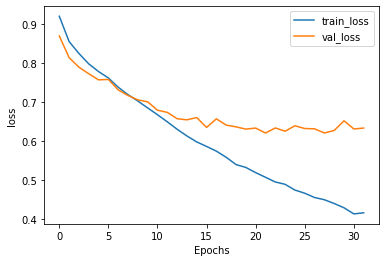

In [95]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()
    
plot_graphs(history, 'loss')
    
#plot_graphs(history, 'accuracy')

In [389]:
# Predict on unlabelled data set

test_emb = text_to_seq(tokenizer, text_corpus =  test.text, max_len = max_len)
pred_test = model.predict(test_emb)
submission_df = pd.read_csv('../input/sample_submission.csv')

submission_df.iloc[:, [1,2,3]] = pred_test

submission_df.to_csv('submit.csv', index=False)

In [96]:
## One bidirectional LSTM layer followed by two dense layers, with the final dense layer being the one with softmax activation

vocab_len = len(word_index) + 1
embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(64, recurrent_dropout=0.5, return_sequences=False)))
model2.add(Dropout(rate = 0.6))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dropout(rate = 0.6))   
model2.add(Dense(units = 3, activation = 'softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history2 = model2.fit(X_train_emb, Y_train_oh, batch_size=128, epochs=100, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15660 samples, validate on 3915 samples
Epoch 1/100
15660/15660 [==============================] - 144s 9ms/step - loss: 1.0235 - val_loss: 0.8900
Epoch 2/100
15660/15660 [==============================] - 140s 9ms/step - loss: 0.8999 - val_loss: 0.8312
Epoch 3/100
15660/15660 [==============================] - 139s 9ms/step - loss: 0.8536 - val_loss: 0.8031
Epoch 4/100
15660/15660 [==============================] - 140s 9ms/step - loss: 0.8325 - val_loss: 0.7777
Epoch 5/100
15660/15660 [==============================] - 140s 9ms/step - loss: 0.8038 - val_loss: 0.7600
Epoch 6/100
15660/15660 [==============================] - 139s 9ms/step - loss: 0.7838 - val_loss: 0.7521
Epoch 7/100
15660/15660 [==============================] - 140s 9ms/step - loss: 0.7640 - val_loss: 0.7281
Epoch 8/100
15660/15660 [==============================] - 140s 9ms/step - loss: 0.7458 - val_loss: 0.7218
Epoch 9/100
15660/15660 [==============================] - 140s 9ms/step - loss: 0.7277 - val_l

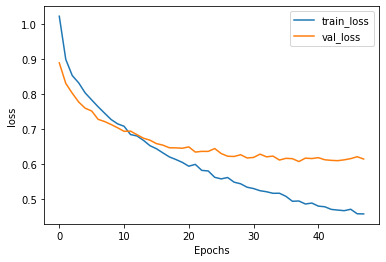

In [97]:
plot_graphs(history2, 'loss')

In [477]:
## Two LSTM layers followed by two dense layers, with the final dense layer being the one with softmax activation

vocab_len = len(word_index) + 1
embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)         
K.clear_session()
model3 = Sequential()
model3.add(embedding_layer)
model3.add(LSTM(64, recurrent_dropout=0.4, return_sequences=True))
model3.add(Dropout(rate = 0.4))
model3.add(LSTM(128, dropout = 0.6, recurrent_dropout=0.5, return_sequences=False))
model3.add(Dense(256, activation = 'relu'))
model3.add(Dropout(rate = 0.6))   
model3.add(Dense(units = 3, activation = 'softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history3 = model3.fit(X_train_emb, Y_train_oh, batch_size=128, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/50
15663/15663 [==============================] - 291s 19ms/step - loss: 1.0284 - val_loss: 0.8706
Epoch 2/50
15663/15663 [==============================] - 267s 17ms/step - loss: 0.9030 - val_loss: 0.8126
Epoch 3/50
15663/15663 [==============================] - 266s 17ms/step - loss: 0.8538 - val_loss: 0.7671
Epoch 4/50
15663/15663 [==============================] - 267s 17ms/step - loss: 0.8251 - val_loss: 0.7506
Epoch 5/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7908 - val_loss: 0.7337
Epoch 6/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7727 - val_loss: 0.7110
Epoch 7/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7607 - val_loss: 0.7215
Epoch 8/50
15663/15663 [==============================] - 266s 17ms/step - loss: 0.7373 - val_loss: 0.6881
Epoch 9/50
15663/15663 [==============================] - 265s 17ms/step - loss: 0.7271 - val_l

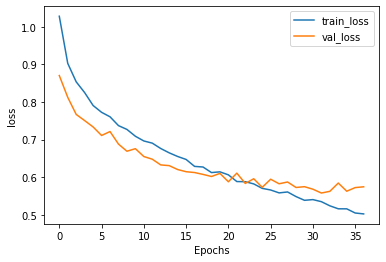

In [478]:
plot_graphs(history3, 'loss')